Student Score Classification With Neural Network

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import shap

In [3]:
# 1. Veri Yükleme
data = pd.read_csv('/content/Student performance in mathematics.csv')

In [4]:
# 2. Hedef Değişken Oluşturma
data['average_score'] = (data['Math score'] + data['Reading score'] + data['Writing score']) / 3

def assign_label(avg):
    if avg < 60:
        return 0  # Başarısız
    elif avg < 80:
        return 1  # Orta
    else:
        return 2  # Başarılı

data['label'] = data['average_score'].apply(assign_label)


In [5]:
# 3. Özellik ve hedef ayrımı
X = data[['Gender', 'Race/ethnicity', 'Parental level of education', 'Lunch', 'Test preparation course',
          'Math score', 'Reading score', 'Writing score']]
y = data['label']

In [6]:
# 4. Preprocessing
categorical_cols = ['Gender', 'Race/ethnicity', 'Parental level of education', 'Lunch', 'Test preparation course']
numeric_cols = ['Math score', 'Reading score', 'Writing score']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

X_processed = preprocessor.fit_transform(X)

In [7]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.4, random_state=42, stratify=y)

print("Eğitim sınıf dağılımı:", pd.Series(y_train).value_counts(normalize=True))
print("Test sınıf dağılımı:", pd.Series(y_test).value_counts(normalize=True))

Eğitim sınıf dağılımı: label
1    0.491935
0    0.258065
2    0.250000
Name: proportion, dtype: float64
Test sınıf dağılımı: label
1    0.481928
0    0.265060
2    0.253012
Name: proportion, dtype: float64


In [8]:
# 6. SMOTE ile Sınıf Dengesi
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Veri Dağılımını Kontrol Et
print("SMOTE sonrası sınıf dağılımı:", pd.Series(y_train).value_counts())

SMOTE sonrası sınıf dağılımı: label
0    61
1    61
2    61
Name: count, dtype: int64


In [9]:
# 7. One-hot Encoding for y
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

In [10]:
# 8. Model Kurulumu
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# 9. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [12]:
# 10. Eğitim
history = model.fit(
    X_train, y_train_categorical,
    epochs=300,
    batch_size=16,
    validation_data=(X_test, y_test_categorical),
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/300
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3588 - loss: 1.8197
Epoch 1: val_accuracy improved from -inf to 0.55422, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.3607 - loss: 1.7936 - val_accuracy: 0.5542 - val_loss: 1.0229 - learning_rate: 0.0010
Epoch 2/300
 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4994 - loss: 1.2874
Epoch 2: val_accuracy improved from 0.55422 to 0.57831, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5270 - loss: 1.2030 - val_accuracy: 0.5783 - val_loss: 0.9600 - learning_rate: 0.0010
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6462 - loss: 0.7767  
Epoch 3: val_accuracy improved from 0.57831 to 0.61446, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6498 - loss: 0.7691 - val_accuracy: 0.6145 - val_loss: 0.9049 - learning_rate: 0.0010
Epoch 4/300
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.95      0.97        40
           2       0.95      1.00      0.98        21

    accuracy                           0.98        83
   macro avg       0.97      0.98      0.98        83
weighted avg       0.98      0.98      0.98        83



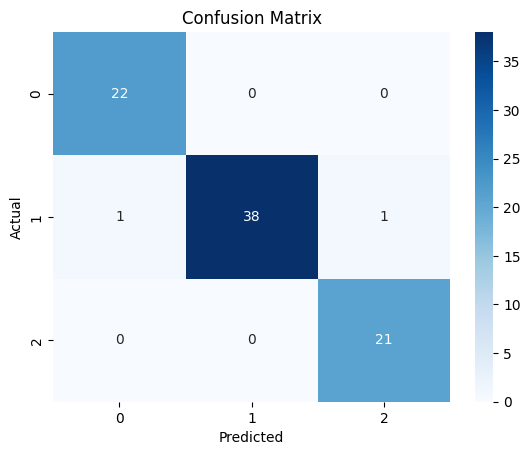

In [13]:
# 11. Değerlendirme
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))

conf_mat = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<Axes: >

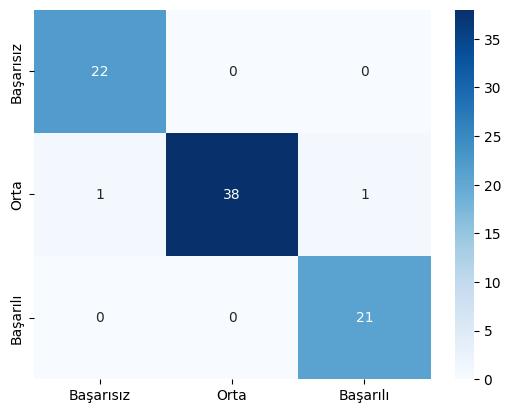

In [14]:
# Türkçe Label Grafik
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Başarısız', 'Orta', 'Başarılı'],
            yticklabels=['Başarısız', 'Orta', 'Başarılı'])

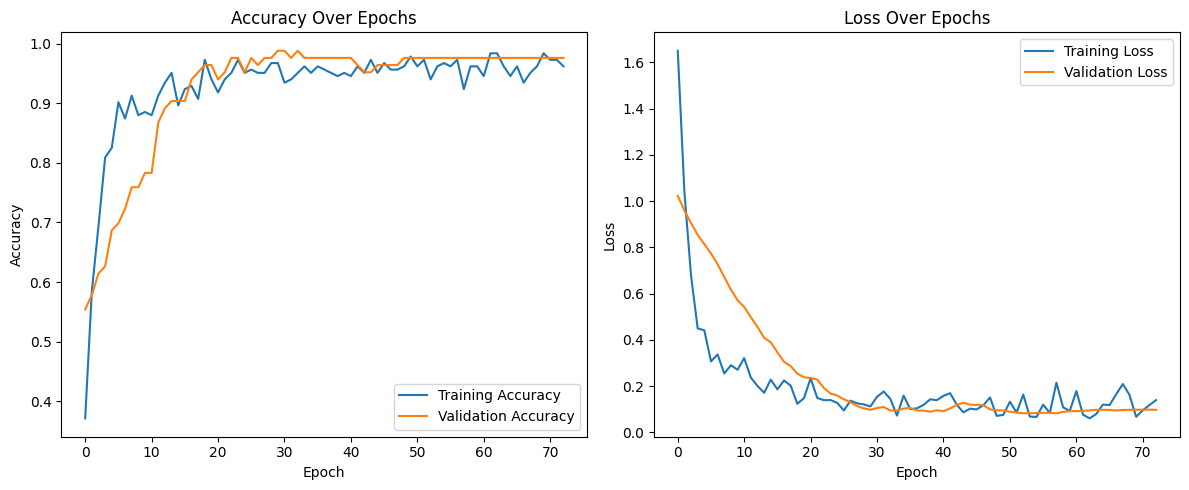

In [15]:
# 12. Eğitim/Kayıp Eğrileri
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()